# The goal is to predict furniture sales data using a univariate time series

In [119]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib
from numpy import array

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [120]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [121]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [122]:
#Dropping features that are not required and summing up sales per day
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')

In [124]:
#averaging out sales per month. We use monthly data as each data point.
furniture = furniture['Sales'].resample('MS').mean()

In [125]:
furniture.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

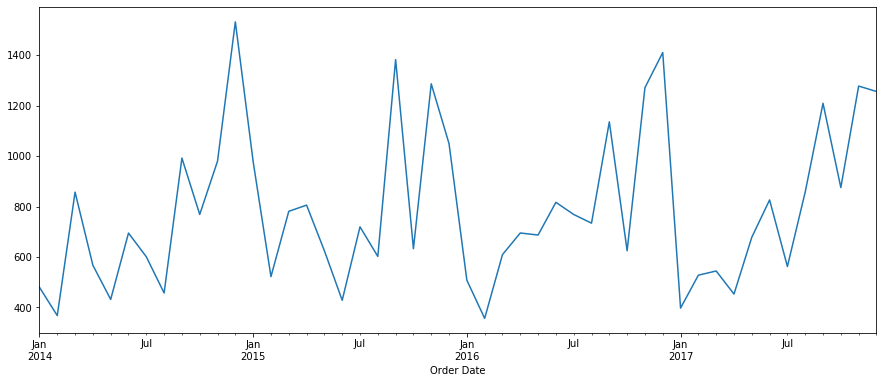

In [126]:
furniture.plot(figsize=(15, 6))
plt.show()

In [127]:
#splitting data from 2014-2016 for training and 2017 for testing
train_sequence = furniture[:'2016']
y_test = furniture['2017':]

## Check for stationarity and find d value

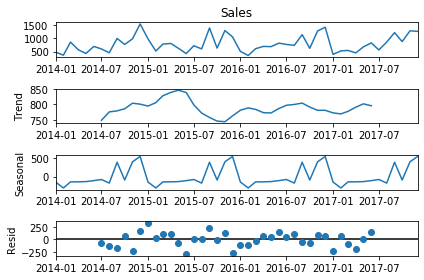

In [128]:
from statsmodels.tsa.seasonal import seasonal_decompose

nresult = seasonal_decompose(y)

nresult.plot()
plt.show()

In [129]:
#p value test for entire data 2014-2017
from statsmodels.tsa.stattools import adfuller
result = adfuller(furniture)
print(result[1])

# p<0.05 This means its stationary, d=0

9.168756655665896e-06


In [106]:
#p value test for testing data only just to ensure statistics are maintained
result = adfuller(y_test)
print(result[1])
#Why 1.0, previously checked? this needs to be addressed

1.0


### Conclusion: differencing of order 1 is required

## Finding p and q values

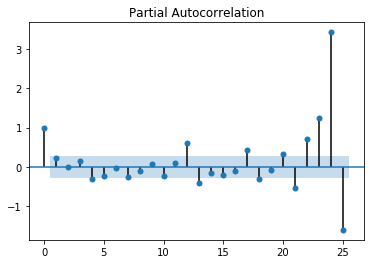

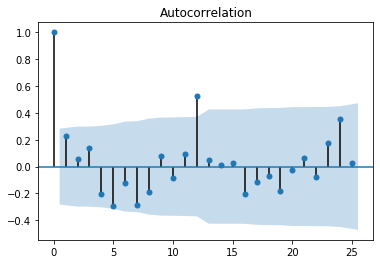

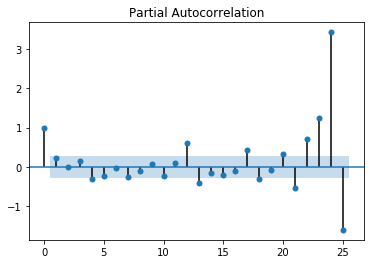

In [107]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y, lags=25)
plot_pacf(y, lags=25)

### Conclusion: p=1 and q=1

## Fitting an Arima model

In [108]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_sequence,order=(1, 1, 1))
results = model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -249.561
Method:                       css-mle   S.D. of innovations            288.877
Date:                Mon, 20 Jul 2020   AIC                            507.121
Time:                        17:14:26   BIC                            513.343
Sample:                    02-01-2014   HQIC                           509.269
                         - 12-01-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.7765      5.778      1.692      0.091      -1.549      21.102
ar.L1.D.Sales     0.2080      0.176      1.182      0.237      -0.137       0.553
ma.L1.D.Sales    -1.0000      0.089    -

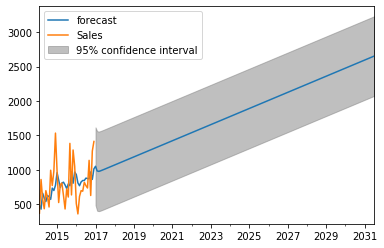

In [109]:
results.plot_predict(1,210)
plt.show()

In [110]:
#assumption is that since the data is seasonal arima doesnt do well
y_pred = results.predict(start='2017-01',end='2017-12')

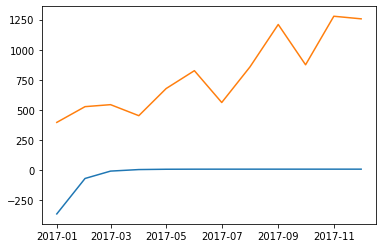

In [111]:
plt.plot(y_pred)
plt.plot(y_test)

### Since arima doesnt support seasonality we try sarima

## Fitting a Sarima model

In [112]:
mod = sm.tsa.statespace.SARIMAX(train_sequence,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   36
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                 -68.902
Date:                             Mon, 20 Jul 2020   AIC                            145.805
Time:                                     17:14:27   BIC                            147.396
Sample:                                 01-01-2014   HQIC                           144.802
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4425      0.536      0.825      0.409      -0.609       1.494
ma.L1          0.0339      

In [113]:
y_pred = results.predict(start='2017-01',end='2017-12')

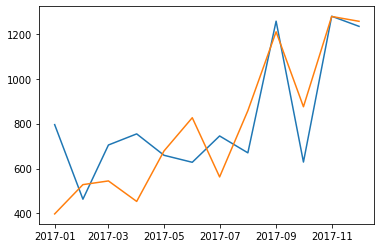

In [114]:
#without differencing AIC = 145
plt.plot(y_pred)
plt.plot(y_test)

# Forecasting 2017 years results and calculating RMSE

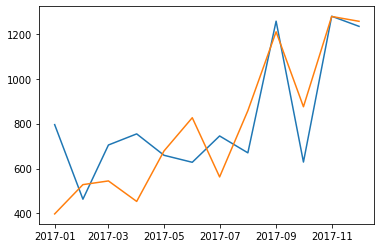

In [116]:
#with differencing AIC = 135
plt.plot(y_pred)
plt.plot(y_test)

In [137]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))
print("rmse for 2017 year predictions using SARIMA: ",rmse)

rmse for 2017 year predictions using SARIMA:  193.86591550039512


### RMSE without differencing is lower which suggests differencing isnt required but AIC without differencing is higher which is a contradiction

# LSTM variations

In [132]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [133]:
n_steps = 3
X_train, y_train = split_sequence(train_sequence, n_steps)
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

In [134]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, y_train, epochs=200, verbose=0)

In [135]:
# demonstrate prediction

x = list(y_test[:n_steps])
forecast = []
for i in range(9):
    x_input = array(x[-n_steps:])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x.append(yhat[0][0])
    forecast.append(yhat[0][0])

In [136]:
rmse = sqrt(mean_squared_error(forecast, y_test[n_steps:]))
print("rmse for 2017 year predictions using LSTM: ",rmse)

rmse for 2017 year predictions:  317.3289019881621


In [92]:
y_test

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64